# Data-Driven ML development usingn Lance

In this notebook we seek to show that:
1. Lance makes it easy to improve model performance without needing a bunch of extra tools
2. Lance can save you significant cost on labeling and storage
3. Lance is customizable so you can tailor insights to your dataset and use case.

We'll walk through a simplified classification model example using the [ImageNet 1K dataset](https://www.image-net.org/index.php) dataset with some pre-trained models. <br/>

First, a few basic setup

In [1]:
import lance
import duckdb
import torchvision
import torch
import pandas as pd
import pyarrow as pa

In [2]:
%load_ext sql
%sql duckdb:///:memory: --connection_arguments {"preload_extensions":["lance"],"config":{"allow_unsigned_extensions":true}}

{'preload_extensions': ['lance'], 'config': {'allow_unsigned_extensions': True}}


In [3]:
# Set this to "generate" to download datasets again for a completely fresh start
MODE = "generate"

In [4]:
if MODE == "generate":
    !rm -rf /tmp/imagenet.lance.tar.gz
    !curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/imagenet_1k.lance.tar.gz --output /tmp/imagenet.lance.tar.gz

!rm -rf /tmp/imagenet*.lance
!cd /tmp && tar -xvf imagenet.lance.tar.gz  # this is fairly large and takes roughly 1min to unzip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6529M  100 6529M    0     0  38.8M      0  0:02:48  0:02:48 --:--:-- 33.0M1:36  0:01:08 43.4M
imagenet_1k.lance/
imagenet_1k.lance/_versions/
imagenet_1k.lance/_versions/1.manifest
imagenet_1k.lance/data/
imagenet_1k.lance/data/a5a0df03-9738-4cec-ae80-594ca2674df8_2.lance
imagenet_1k.lance/data/a5a0df03-9738-4cec-ae80-594ca2674df8_5.lance
imagenet_1k.lance/data/a5a0df03-9738-4cec-ae80-594ca2674df8_0.lance
imagenet_1k.lance/data/a5a0df03-9738-4cec-ae80-594ca2674df8_3.lance
imagenet_1k.lance/data/a5a0df03-9738-4cec-ae80-594ca2674df8_4.lance
imagenet_1k.lance/data/a5a0df03-9738-4cec-ae80-594ca2674df8_1.lance
imagenet_1k.lance/_latest.manifest


Data is stored on disk (local, s3, gcs, etc) and no database/infra is needed

In [5]:
uri = "/tmp/imagenet_1k.lance"
ds = lance.dataset(uri)

We'll need the class map

In [7]:
from imagenet_classes import IMAGENET2012_CLASSES

imagenet_classes = (pd.Series(IMAGENET2012_CLASSES)
                    .reset_index(name='name')
                    .drop(columns="index")
                    .reset_index()
                    .rename(columns={'index': 'label'}))

In [8]:
ds = ds.merge(pa.Table.from_pandas(imagenet_classes), left_on="class", right_on="name")

## Basic EDA with Lance

Lance supports a wide range of computational libraries and engines.<br/>
This makes it easy to do basic data exploration using say DuckDB or pandas.

In [9]:
%%sql

SELECT image_id, image_uri, class, label, split
FROM ds
WHERE class <> ''
USING SAMPLE 10

Took 0.034531354904174805


,image_id,image_uri,class,label,split
0,n02708093_5803,https://eto-public.s3.amazonaws.com/datasets/i...,analog clock,409,train
1,n02123597_13027,https://eto-public.s3.amazonaws.com/datasets/i...,Siamese cat,0,train
2,n04476259_13040,https://eto-public.s3.amazonaws.com/datasets/i...,tray,868,train
3,n03384352_16599,https://eto-public.s3.amazonaws.com/datasets/i...,forklift,561,train
4,n03124170_7819,https://eto-public.s3.amazonaws.com/datasets/i...,cowboy hat,0,train
5,n02114367_8566,https://eto-public.s3.amazonaws.com/datasets/i...,timber wolf,0,train
6,n02607072_5458,https://eto-public.s3.amazonaws.com/datasets/i...,anemone fish,393,train
7,n03126707_24249,https://eto-public.s3.amazonaws.com/datasets/i...,crane bird,0,train
8,ILSVRC2012_val_00004068,https://eto-public.s3.amazonaws.com/datasets/i...,hatchet,596,val


### Simple summary statistics

You can load Lance datasets into pandas

In [10]:
(ds.scanner(columns=["split"])
 .to_table().to_pandas()
 .split.value_counts())

train    47041
test      8638
val       4002
Name: split, dtype: int64

### Check label distribution

Note the you can also work with Lance datasets using SQL

In [11]:
%%sql label_counts <<

SELECT class, count(class) as count
FROM ds
WHERE split <> 'test'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10

Took 0.013085603713989258


,class,count
0,boxer,116
1,crane bird,116
2,seashore,114
3,standard poodle,112
4,stove,108
5,trailer truck,107
6,Border collie,107
7,Doberman,104
8,golden retriever,96
9,maillot,95


<AxesSubplot: xlabel='class'>

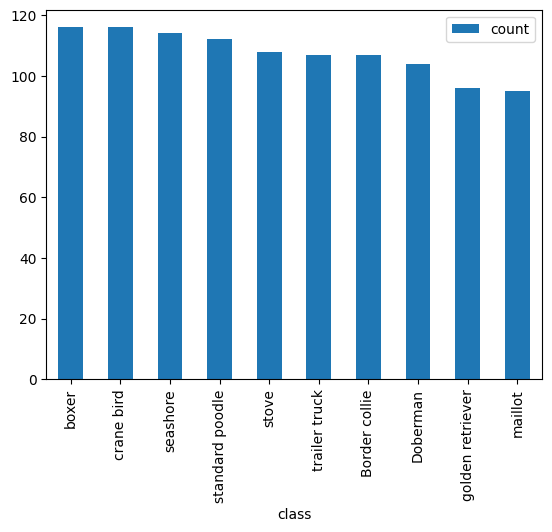

In [12]:
label_counts.set_index('class').plot.bar()

## Evaluating Model performance

### Inference

We load two pretrained classic CNN and Transformer models to help us understand the dataset better.

* The ResNet model is based on the [Deep Residual Learning for Image Recognition paper](https://arxiv.org/abs/1512.03385)
* The VisionTransformer model is based on the [An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale paper](https://arxiv.org/abs/2010.11929).

Models are moved to the accelerators if available. 
Not only we support CUDA as backend, we support [MPS backend on macOS](https://pytorch.org/docs/stable/notes/mps.html) as well.

In [13]:
from torchvision.models import resnet50, vit_b_16
import torch

# Support CUDA (Linux) or MPS (Mac) backends.
device = torch.device(
    "cuda" if torch.cuda.is_available() else (
        "mps" if torch.backends.mps.is_available() else "cpu")
)

resnet = resnet50(weights="DEFAULT").to(device)
vit = vit_b_16(weights="DEFAULT").to(device)

Lance provides native [PyTorch Dataset](https://eto-ai.github.io/lance/api/python/lance.pytorch.html#lance.pytorch.data.Dataset),
which works with PyTorch DataLoader.

We can write a plain PyTorch evaluation loop and persist the predictions back to the dataset for future analysis.



In [14]:
from lance.pytorch import Dataset

def run_inference(uri: str, model, transform, col_name: str) -> pa.Table:
    dataset = Dataset(
        uri, 
        columns=["image_id", "image"],
        mode="batch",
        batch_size=128
    )
    results = []
    with torch.no_grad():
        model.eval()
        for batch in dataset:
            imgs = [transform(img).to(device) for img in batch[1]]
            prediction = resnet(torch.stack(imgs)).squeeze(0).softmax(0)
            topk = torch.topk(prediction, 2)
            for pk, scores, indices in zip(
                batch[0], topk.values.tolist(), topk.indices.tolist()
            ):
                results.append({
                    "image_id": pk.item(),
                    col_name: {
                        "label": indices[0], 
                        "score": scores[0], 
                        "second_label": indices[1],  # Secondary guess
                        "second_score": scores[1],  # Confidence of the secondary guess.
                    }
                })
    df = pd.DataFrame(data=results)
    return pa.Table.from_pandas(df)

In [16]:
if MODE == 'generate':
    resnet_table = run_inference(
        uri, resnet, torchvision.models.ResNet50_Weights.DEFAULT.transforms(), "resnet"
    )
    vit_table = run_inference(
        uri, vit, torchvision.models.ViT_L_16_Weights.DEFAULT.transforms(), "vit"
    )
    !rm -rf /tmp/resnet_table.lance
    !rm -rf /tmp/vit_table.lance
    lance.write_dataset(resnet_table, "/tmp/resnet_table.lance")
    lance.write_dataset(vit_table, "/tmp/vit_table.lance")
else:
    resnet_table = lance.dataset("/tmp/resnet_table.lance").to_table()
    vit_table = lance.dataset("/tmp/vit_table.lance").to_table()

### Add inference results to dataset without copying

Because Lance supports [Schema Evolution](https://en.wikipedia.org/wiki/Schema_evolution), 
it is quite easy to add new columns from the model inference back to the dataset.

In [17]:
ds = ds.merge(resnet_table, left_on="image_id", right_on="image_id")
ds = ds.merge(vit_table, left_on="image_id", right_on="image_id")

In [18]:
ds.versions()

[{'version': 1,
  'timestamp': datetime.datetime(2022, 12, 21, 20, 9, 43, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 2,
  'timestamp': datetime.datetime(2022, 12, 21, 20, 22, 5, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 3,
  'timestamp': datetime.datetime(2022, 12, 21, 20, 22, 47, tzinfo=datetime.timezone.utc),
  'metadata': {}},
 {'version': 4,
  'timestamp': datetime.datetime(2022, 12, 21, 20, 22, 47, tzinfo=datetime.timezone.utc),
  'metadata': {}}]

In [19]:
lance.diff(ds, 1, 2).columns_added().schema

label: int64

In [20]:
lance.diff(ds, 2, 3).columns_added().schema

resnet.label: int64
resnet.score: double
resnet.second_label: int64
resnet.second_score: double

In [21]:
lance.diff(ds, 3, 4).columns_added().schema

vit.label: int64
vit.score: double
vit.second_label: int64
vit.second_score: double

In [22]:
diff = lance.diff(ds, 1, 4).columns_added()
diff.head().to_pandas()

,label,resnet,vit
0,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
1,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
2,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
3,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
4,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
5,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
6,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
7,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
8,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."
9,282,"{'label': 0, 'score': 0.0, 'second_label': 0, ...","{'label': 0, 'score': 0.0, 'second_label': 0, ..."


<div class="alert alert-block alert-info"> 
    💡 This versioning happens without manually work or redundant copying   
</div>

## ML metrics

Using SQL it's easy and fast to integrate Lance with BI tooling or visualization libraries to compute and visualize ML metrics

For example, it would be simple to generate SQL to compute model precision

In [23]:
%%sql precision <<

SELECT 
  SUM(CAST(resnet.label = ds.label AS FLOAT)) / COUNT(ds.label) as resnet,
  SUM(CAST(vit.label = ds.label AS FLOAT)) / COUNT(ds.label) as vit
FROM ds
WHERE split = 'val'

Took 0.018708467483520508


,resnet,vit
0,0.47901,0.48026


<AxesSubplot: >

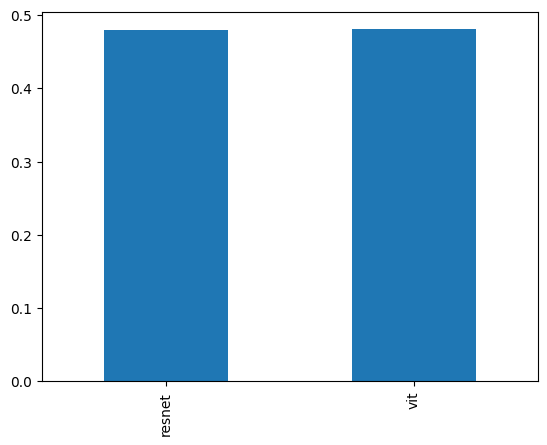

In [24]:
precision.T.rename(columns={0: 'precision'}).squeeze().plot.bar()

### Digging into arbitrary slices

With Lance, it is trivial to slice into each label class to detailed model performance in each class.

In [25]:
%%sql precision_by_class <<

SELECT
  ds.class,
  SUM(CAST(resnet.label = ds.label AS FLOAT)) / COUNT(ds.label) as resnet,
  SUM(CAST(vit.label = ds.label AS FLOAT)) / COUNT(ds.label) as vit
FROM ds
WHERE split = 'val'
GROUP BY 1
ORDER BY resnet ASC

Took 0.0226438045501709


,class,resnet,vit
0,Appenzeller,0.0,0.0
1,Band Aid,0.0,0.0
2,Bedlington terrier,0.0,0.0
3,Border collie,0.0,0.0
4,Brabancon griffon,0.0,0.0
...,...,...,...
993,silky terrier,1.0,1.0
994,wardrobe,1.0,1.0
995,ringneck snake,1.0,1.0
996,seat belt,1.0,1.0


<AxesSubplot: xlabel='class'>

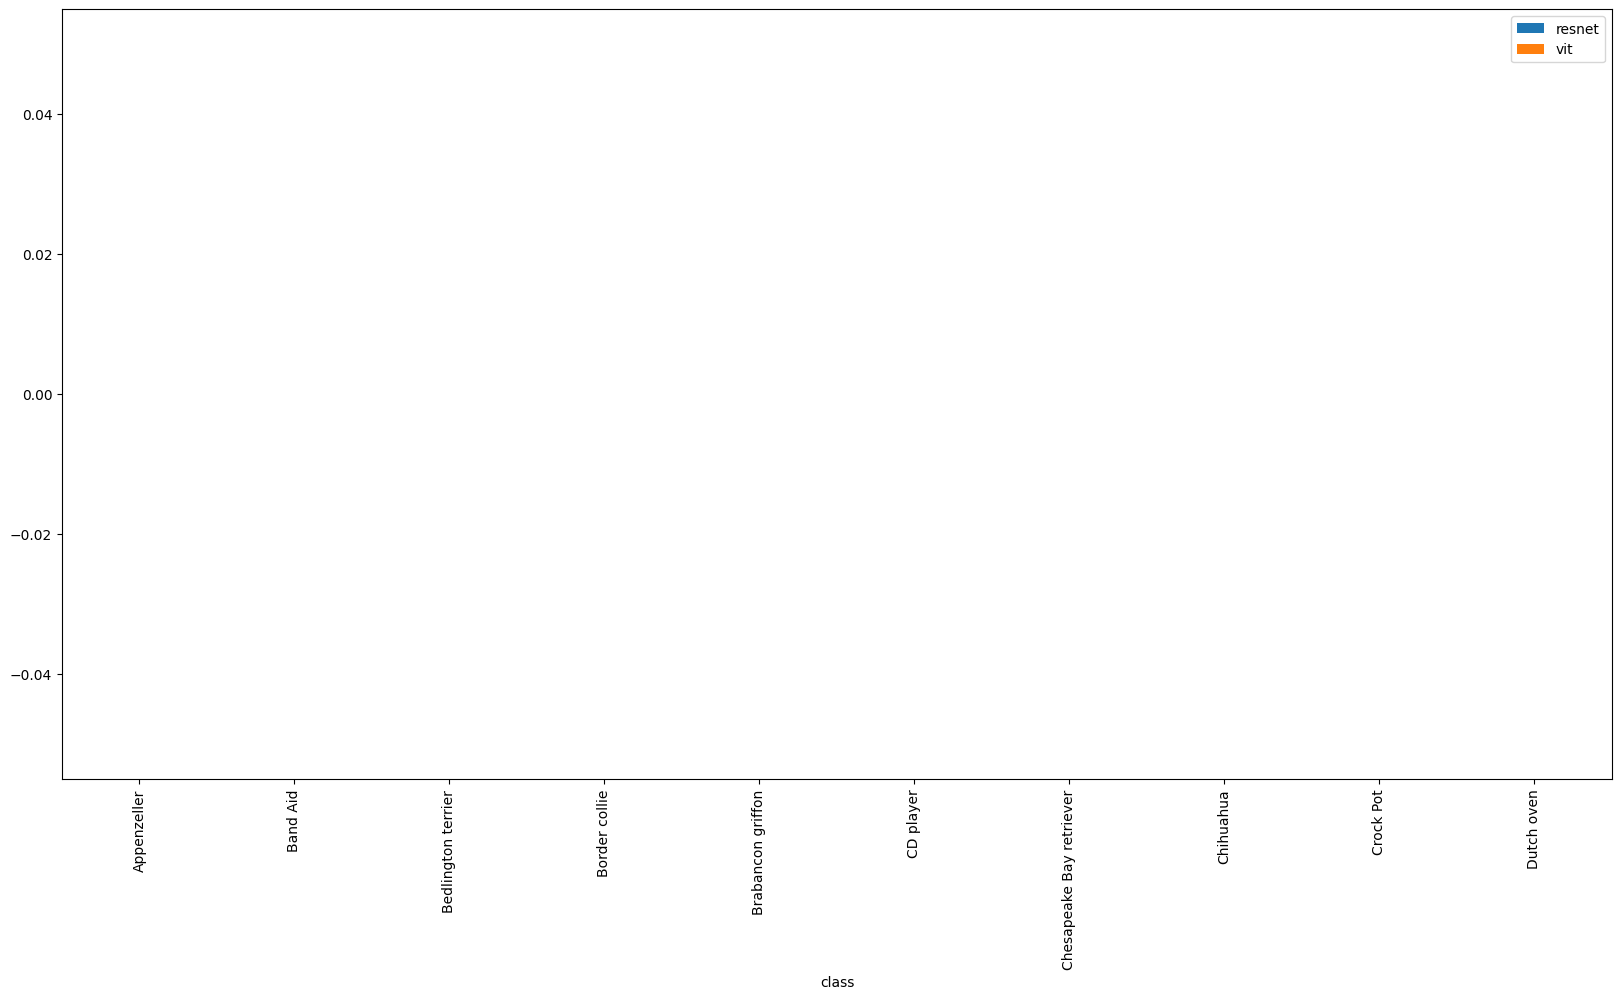

In [26]:
precision_by_class.head(10).set_index('class').plot.bar(figsize=(20,10))

### Confusion matrix

In [ ]:
%%sql confusion <<

WITH label_names AS (SELECT DISTINCT label, name FROM imagenet_classes)

SELECT ds.class as gt, label_names.name as resnet
FROM ds, label_names
WHERE ds.resnet.label=label_names.label

In [ ]:
rs = confusion.reset_index().groupby(['gt', 'resnet']).count().reset_index().rename(columns={'index': 'count'})

In [ ]:
rs["pct"] = rs.groupby("gt", group_keys=False)["count"].apply(lambda grp: grp / grp.sum())

In [ ]:
import seaborn as sns

sns.heatmap((rs[rs["gt"] != rs["resnet"]]
             .sort_values("pct", ascending=False).head(10)
             .set_index(["gt", "resnet"])["count"].unstack("gt")))

<div class="alert alert-block alert-info"> 
    💡 INSIGHT: top confused classes are often very similar. We can focus on these categories to improve model performance much more efficiently than adding data using random sampling
</div>

## Automatically Detecting Mislabels

Sometimes it's not the model but the labels that are wrong. Even a few bad labels can have outsized impact on model accuracy so it's critical we find them. To find potential mislables, we first need to automately establish a baseline of what consider as correct labels.

We establish the baseline via the agreements of the two pre-trained models inference results. That is,
if the two models strongly agree with each other (i.e., same label and confience score is high), but the predict label is not what ground truth describes.

Such logic can be easily expressed via SQL:

In [ ]:
%%sql df <<

WITH label_names AS (SELECT DISTINCT label, class as name FROM ds where class <> '')

SELECT ds.image_id,
       ds.image_uri,
       ds.class AS ground_truth,
       n2.name as predict,
       resnet.score as score
FROM ds, label_names as n1, label_names as n2
WHERE
  split != 'test'
  AND n1.label !=  resnet.label 
  AND resnet.label = vit.label
  AND ds.class = n1.name
  AND resnet.label = n2.label
ORDER BY resnet.score DESC
LIMIT 20

Btw Lance's UI can be embedded in a notebook and can interact with the notebook kernel (does not require external server)

### Labeling integration

With Lance you can save labeling cost:
1. No need to pay label service to manage data points you'll never label
2. Data insights increases the efficiency of each label
3. Easy integration to open-source labeling tools like Label Studio

In [ ]:
from labelstudio import LanceLabelStudioClient as Client

ls = Client.create()
p = ls.get_project("imagenet")

p.add_tasks(df.head(5), image_col="image_uri", pk_col="image_id")

Once labeled, we merge the new labels back into the dataset

In [ ]:
import pyarrow as pa
label_df = p.get_annotations("label_studio_labels")

schema = pa.schema([pa.field('id', pa.string()),
                    pa.field('label_studio_labels', pa.string())])
tbl = pa.Table.from_pandas(label_df, schema)

In [ ]:
ds = ds.merge(tbl, left_on='image_id', right_on='id')

Again, Lance automatically versions the changes so it's easy to diff and rollback

In [ ]:
diff = lance.diff(ds, -2).columns_added()
diff.schema

In [ ]:
df = diff.head(n=ds.count_rows()).to_pandas()
df[df.label_studio_labels != ""]

### Retrain without copying or converting

Lance has native pytorch support so you can re-train the model without converting / copying the dataset into a pytorch compatible format

In [ ]:
import pyarrow.compute as pc

dataset = Dataset(
    uri,
    filter=pc.field("split") == "train",
    columns=["image_id", "class", "image"],  # only read certain columns
    batch_size=1
)

for batch in dataset:
    print(batch)
    break

## Active Learning with Lance

With active learning, we can get significantly better model performance on fewer labels. <br/>
With Lance and DuckDB, it is easy to build active learning loop as well.

One typical approach of Active Learning is finding `Lowest Margin of Confidence`. 

This query finds the examples where a model (*ResNet* in this case) is less confident between the top two candidates.

In [ ]:
%%sql least_margin <<

WITH label_names AS (SELECT DISTINCT label, name FROM imagenet_classes)

SELECT    
    ds.image_id,
    ds.image_uri,
    n1.name as best_guess,
    n2.name as second_guess,
    resnet.score - resnet.second_score AS margin_of_confidence
FROM ds, label_names as n1, label_names as n2
WHERE 
    split != 'test'
    AND n1.label = resnet.label
    AND n2.label = resnet.second_label
ORDER BY margin_of_confidence
LIMIT 20

### Finding similar examples

Once we know these low confidence examples, we can find similar out-of-sample data to augment our training dataset using Lance's ML functions in DuckDB

Get out of sample data

In [ ]:
if MODE == "generate":
    !rm -rf /tmp/out_of_sample.lance.tar.gz
    !curl https://eto-public.s3.amazonaws.com/datasets/imagenet_1k/imagenet1k_20k.lance.tar.gz --output /tmp/out_of_sample.lance.tar.gz
!cd /tmp && tar -xvf out_of_sample.lance.tar.gz

Embeddings extractor

In [ ]:
import pyarrow as pa
from torchvision.models.feature_extraction import create_feature_extractor

resnet = resnet50(weights="DEFAULT")
resnet_extractor = create_feature_extractor(resnet, {"avgpool": "features"}).to("cuda")
resnet_extractor.eval()

resnet_transforms = torchvision.models.ResNet50_Weights.DEFAULT.transforms()


def compute_resnet_embeddings(uri):
    image_ids = []
    embeddings = []
    with torch.no_grad():
        for batch in Dataset(uri,
                             columns=["image_id", "image"],
                             mode="batch", batch_size=128):
            imgs = torch.stack([resnet_transforms(img) for img in batch[1]]).to("cuda")
            resnet_out = resnet_extractor(imgs)["features"].squeeze()
            features = torch.softmax(resnet_out, dim=1).cpu()
            embeddings.extend(features.tolist())
            image_ids.extend(batch[0])
            
    emb_type = pa.list_(pa.float32(), list_size=2048)
    arrays = [pa.array(image_ids), pa.array(embeddings, type=emb_type)]
    schema=pa.schema([pa.field("image_id", pa.string()), 
                      pa.field("embedding", emb_type)])

    tbl = pa.Table.from_arrays(arrays, schema=schema)
    return tbl

Compute embeddings for out-of-sample data

In [ ]:
uri = "/tmp/imagenet1k_20k.lance"
if MODE == "generate":
    embeddings = compute_resnet_embeddings(uri)
    !rm -rf /tmp/embeddings.lance
    lance.write_dataset(embeddings, '/tmp/embeddings.lance')
else:
    embeddings = lance.dataset("/tmp/embeddings.lance").to_table()

In [ ]:
out_of_sample = lance.dataset(uri)
out_of_sample.merge(embeddings, left_on="image_id", right_on="image_id")
out_of_sample = lance.dataset(uri)

Compute embeddings for training set using same model

In [ ]:
uri = "/tmp/imagenet_1k.lance"
if MODE == "generate":
    embeddings = compute_resnet_embeddings(uri)
    !rm -rf /tmp/embeddings_train.lance
    lance.write_dataset(embeddings, '/tmp/embeddings_train.lance')
else:
    embeddings = lance.dataset("/tmp/embeddings_train.lance").to_table()

In [ ]:
training_set = lance.dataset(uri)
training_set.merge(embeddings, left_on="image_id", right_on="image_id")
training_set = lance.dataset(uri)

### Lance has ML functions for duckdb to compute similarity

In [ ]:
least_margin.iloc[0]

In [ ]:
%%sql --lance

with ref as (select embedding from training_set where image_id='n02120079_488')

SELECT image_id, image_uri, l2_distance(oos.embedding, ref.embedding) as similarity
FROM out_of_sample oos cross join ref
ORDER BY 3
LIMIT 10

### Label then re-train

Just like we did before, using LabelStudio integration and pytorch integration, it's easy to add these new data points to your dataset and improve your model

## Lance makes it super-simple to create a Data-Driven ML development loop

- Get insights in under 100ms via duckdb or pandas

- Save labeling cost by only sending samples that need to be labeled to Scale/LabelBox. Or totally free using LabelStudio.

- Lance dashboards and insights are customizable so you can tailor it to your use case exactly